## 京东指数转化(5月1日后改版)

In [201]:
import pandas as pd 
import numpy as np
from scipy.optimize import curve_fit  
import matplotlib.pyplot as plt 
# from sklearn import cross_validation
from impala.dbapi import connect
from impala.util import as_pandas
import json
import pymysql
from sqlalchemy import create_engine
import os
import xlsxwriter
import openpyxl
from openpyxl import Workbook, load_workbook
from openpyxl.styles import PatternFill, Border, Side, Alignment, Protection, Font
from openpyxl.utils import get_column_letter
from openpyxl.styles import numbers
# 邮件模块
import smtplib
from smtplib import SMTP
from email.mime.text import MIMEText
from email.header import Header
from email.mime.application import MIMEApplication
from email.mime.multipart import MIMEMultipart 

In [90]:
# 读取训练数据拟合
data1 = pd.read_excel('belle官方旗舰店数据拟合.xlsx', sheet_name = 'Sheet2')
data1.head()

,成交金额指数,成交金额
0,54859,182.000000
1,63856,216.449997
2,67062,229.000000
3,69591,239.000000
4,70483,242.550003


In [91]:
data1.describe()

,成交金额指数,成交金额
count,2.745000e+03,2.745000e+03
mean,6.196724e+06,1.488465e+05
std,1.134843e+07,4.784751e+05
min,5.485900e+04,1.820000e+02
25%,6.550270e+05,3.850100e+03
50%,2.088317e+06,1.857200e+04
75%,6.855438e+06,9.748515e+04
max,1.383399e+08,8.560942e+06


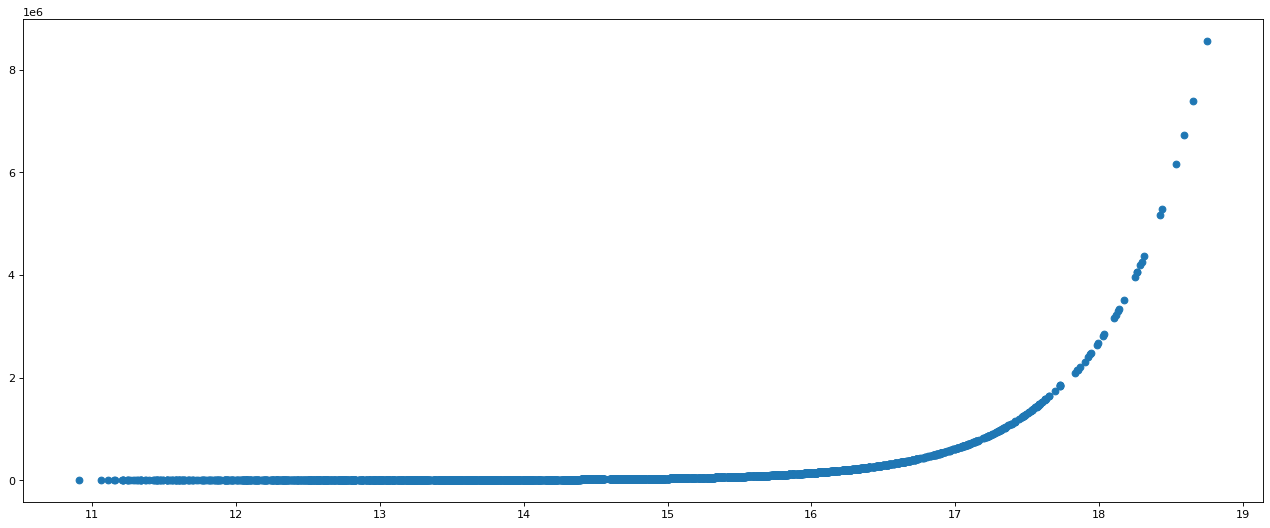

In [92]:
# 散点图查看指数与金额的趋势
_x = np.log(data1['成交金额指数'])
_y = data1['成交金额']
plt.figure('所有点', figsize= (20,8), dpi =80)
plt.scatter(_x, _y)
plt.show() # 整体趋势呈现某个指数形式增长

##  gmv = a x exp(ln(指数) x b)

In [93]:
def fund(x, a, b):  
    """gmv = a*exp(ln指数*b)"""
    return a * np.exp(b * x)
def cur_fitted(i,j,data1):
    """gmv = a*exp(ln指数*b)"""
    _x = data1['成交金额指数']
    _y = data1['成交金额']
    _x1 = _x[i:j]
#     _y1 = np.log(_x1)
    xdata= np.log(_x1)
    ydata =_y[i:j]
    plt.scatter(xdata,ydata)  
    popt, pcov = curve_fit(fund, xdata, ydata,maxfev=500000) 
    y2 = [fund(i, popt[0],popt[1]) for i in xdata]  
    plt.plot(xdata,y2,'r--')
    error_c = (y2- ydata)/ydata*100
    cur_result = pd.DataFrame([list(_x1),list(ydata),y2,list(error_c)]).T
    cur_result.columns = ['指数','实际值','拟合值','误差率（%）']
    return popt,cur_result

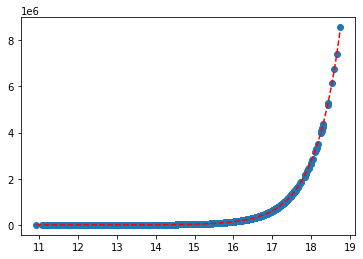

In [76]:
### 整体拟合：
popt, result = cur_fitted(0,len(data1),data1)

In [77]:
len(data1)

2746

In [159]:
list1 = [0, 25,60,100,200,360,400,417,450,500,800,1200,1300,1340,1420,1500,2000,2200,2300,2350,2400,2500,2550,2600,2630,2650,2680,2710,2725,len(data1)] #  初次分割点b

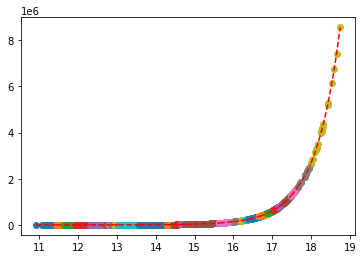

In [160]:
list2 = list()
df_result = pd.DataFrame()
df_c = pd.DataFrame()
for i in range(len(list1)-1):
    popt, result = cur_fitted(list1[i],list1[i+1],data1)
    df_result = pd.concat([df_result,result])
    df_c = pd.concat([df_c,pd.DataFrame(popt).T])
#     print(popt)

In [161]:
df_c.columns =['a','b']
list1.pop()
z = data1.iloc[list1,]['成交金额指数']
df_c.index = z

In [ ]:
# 分界点误差修正
df_c.index = [3149,
6327,
10410,
15889,
27421,
47502,
83224,
139819,
231312,
364353,
633737,
1168266,
2046629,
2885835,
4054150,
6351837,
11381641,
19843880,
40680596,
57511448,
87237192,
121426784,
242576256
]

In [105]:
df_c

,a,b
成交金额指数,,
54859,0.000558,1.162986
91965,0.000409,1.190250
113683,0.000317,1.212162
152684,0.000228,1.239526
223476,0.000159,1.269006
335992,0.000128,1.285962
365478,0.000122,1.289588
381416,0.000120,1.289689
415836,0.000111,1.295906


In [104]:
len(df_c)

30

In [98]:
df_result.head()

,指数,实际值,拟合值,误差率（%）
0,54859.0,182.000000,181.300275,-0.384464
1,63856.0,216.449997,216.322564,-0.058874
2,67062.0,229.000000,229.004544,0.001984
3,69591.0,239.000000,239.078724,0.032939
4,70483.0,242.550003,242.646347,0.039721


In [44]:
# df_result['指数'] = data1['成交金额指数']

In [103]:
writer = pd.ExcelWriter('belle店铺金额拟合结果3.xlsx')
df_result.to_excel(writer,encoding= 'gbk', sheet_name='拟合值及误差',index =None)
df_c.to_excel(writer,encoding= 'gbk', sheet_name='分段函数系数')
writer.close()

In [162]:
def fun_fit(x):
    global df_c
    list3 = df_c.index
    if list3[0]<=x<list3[1]:
        a = df_c.loc[list3[0],'a']
        b = df_c.loc[list3[0],'b']
    elif list3[1]<=x<list3[2]:
        a = df_c.loc[list3[1],'a']
        b = df_c.loc[list3[1],'b']  
    elif list3[2]<=x<list3[3]:
        a = df_c.loc[list3[2],'a']
        b = df_c.loc[list3[2],'b']  
    elif list3[3]<=x<list3[4]:
        a = df_c.loc[list3[3],'a']
        b = df_c.loc[list3[3],'b']
    elif list3[4]<=x<list3[5]:
        a = df_c.loc[list3[4],'a']
        b = df_c.loc[list3[4],'b']
    elif list3[5]<=x<list3[6]:
        a = df_c.loc[list3[5],'a']
        b = df_c.loc[list3[5],'b']  
    elif list3[6]<=x<list3[7]:
        a = df_c.loc[list3[6],'a']
        b = df_c.loc[list3[6],'b']  
    elif list3[7]<=x<list3[8]:
        a = df_c.loc[list3[7],'a']
        b = df_c.loc[list3[7],'b']
    elif list3[8]<=x<list3[9]:
        a = df_c.loc[list3[8],'a']
        b = df_c.loc[list3[8],'b']  
    elif list3[9]<=x<list3[10]:
        a = df_c.loc[list3[9],'a']
        b = df_c.loc[list3[9],'b']  
    elif list3[10]<=x<list3[11]:
        a = df_c.loc[list3[10],'a']
        b = df_c.loc[list3[10],'b']
    elif list3[11]<=x<list3[12]:
        a = df_c.loc[list3[11],'a']
        b = df_c.loc[list3[11],'b']
    elif list3[12]<=x<list3[13]:
        a = df_c.loc[list3[12],'a']
        b = df_c.loc[list3[12],'b']  
    elif list3[13]<=x<list3[14]:
        a = df_c.loc[list3[13],'a']
        b = df_c.loc[list3[13],'b']  
    elif list3[14]<=x<list3[15]:
        a = df_c.loc[list3[14],'a']
        b = df_c.loc[list3[14],'b']
    elif list3[15]<=x<list3[16]:
        a = df_c.loc[list3[15],'a']
        b = df_c.loc[list3[15],'b']  
    elif list3[16]<=x<list3[17]:
        a = df_c.loc[list3[16],'a']
        b = df_c.loc[list3[16],'b']  
    elif list3[17]<=x<list3[18]:
        a = df_c.loc[list3[17],'a']
        b = df_c.loc[list3[17],'b']
    elif list3[18]<=x<list3[19]:
        a = df_c.loc[list3[18],'a']
        b = df_c.loc[list3[18],'b']
    elif list3[19]<=x<list3[20]:
        a = df_c.loc[list3[19],'a']
        b = df_c.loc[list3[19],'b']
    elif list3[20]<=x<list3[21]:
        a = df_c.loc[list3[20],'a']
        b = df_c.loc[list3[20],'b']
    elif list3[21]<=x<list3[22]:
        a = df_c.loc[list3[21],'a']
        b = df_c.loc[list3[21],'b']
    elif list3[22]<=x<list3[23]:
        a = df_c.loc[list3[22],'a']
        b = df_c.loc[list3[22],'b']
    elif list3[23]<=x<list3[24]:
        a = df_c.loc[list3[23],'a']
        b = df_c.loc[list3[23],'b']
    elif list3[24]<=x<list3[25]:
        a = df_c.loc[list3[24],'a']
        b = df_c.loc[list3[24],'b']
    elif list3[25]<=x<list3[26]:
        a = df_c.loc[list3[25],'a']
        b = df_c.loc[list3[25],'b']
    elif list3[26]<=x<list3[27]:
        a = df_c.loc[list3[26],'a']
        b = df_c.loc[list3[26],'b']
    elif list3[27]<=x<list3[28]:
        a = df_c.loc[list3[27],'a']
        b = df_c.loc[list3[27],'b']
    # elif list3[28]<=x<list3[29]:
    #     a = df_c.loc[list3[28],'a']
    #     b = df_c.loc[list3[28],'b']
    else:
        a = df_c.loc[list3[28],'a']
        b = df_c.loc[list3[28],'b']
    y = fund(np.log(x),a,b)
    return y

In [108]:
data1['拟合值'] = data1['成交金额指数'].map(lambda x:fun_fit(x))
data1['误差值']= (data1['拟合值']- data1['成交金额'])/ data1['成交金额']*100

In [109]:
data1.to_csv('belle拟合指与误差v1.csv',index = None,encoding = 'gbk')
# df_c.to_excel('分段系数表.xlsx',sheet_name = '系数表')

In [ ]:
# data1.head()
# plt.scatter(range(len(data1['误差值'])),data1['误差值']) # 误差散点图

## 金额指数转换

In [164]:
fun_fit(2186848) # 2177277


19373.663865572275

## 集群取数

In [113]:
#### 京东指数取数
# 连接集群hive/impala
def impala_connect(sql, **kwargs):
# impala 
    host = kwargs.get("host", 'impala.bjds.belle.lan')
    port = kwargs.get("port", 21051)    
    timeout = kwargs.get("timeout", 3600)
# hive
    # host = kwargs.get("host", 'impala.bjds.belle.lan')
    # port = kwargs.get("port", 10008)    
    # timeout = kwargs.get("timeout", 3600)
    user = kwargs.get("user", "lv.d.sz")
    password = kwargs.get("password", 'JHjLXpyQ')
    kerberos_service_name = kwargs.get("kerberos_service_name", "impala")
    conn = connect(host=host, port=port, timeout=timeout, user=user, password=password, kerberos_service_name=
                   kerberos_service_name,auth_mechanism='LDAP')
    cur = conn.cursor(user=user)
    if sql is not None:
        cur.execute(sql)
        try:
            df = as_pandas(cur)
        except:
            return cur
    return df

In [174]:
def act_node(date_str):
    if date_str<='2020-05-31':
        c = '预售期&预热期'
    elif date_str<='2020-06-15':
        c = '专场期'
    elif date_str<='2020-06-20':
        c = '高潮期'
    elif date_str == '2020-06-21':
        c = '还场期'
    return c

In [186]:
sql_vender_day= """
-- 二级品类店铺top100日度数据
select category as `一级类目`,
child_category as `子类目`, 
start_day as `日期`, 
end_day,
date_type, 
rank  as `排名`, 
shop_name `店铺名`,
gmv_amount_index as `成交金额指数`,
order_num_index as `成交单量指数`,
follow_num as `关注人数`,
visitor_index as `访客指数`,
search_click_index as `搜索点击指数`
from  bi_analysis.jd_sz_vender_ranks where 
category in ('时尚女鞋','流行男鞋','潮流女包')
 and child_category = ""
and start_day = '%s'
and end_day = '%s'
-- and length(date_type) = 6
and belle_shop_name = '百丽官方旗舰店'
order by start_day, category, rank
"""

In [187]:
last_day = '2020-05-21'

In [191]:
print(sql_f)


-- 二级品类店铺top100日度数据
select category as `一级类目`,
child_category as `子类目`, 
start_day as `日期`, 
end_day,
date_type, 
rank  as `排名`, 
shop_name `店铺名`,
gmv_amount_index as `成交金额指数`,
order_num_index as `成交单量指数`,
follow_num as `关注人数`,
visitor_index as `访客指数`,
search_click_index as `搜索点击指数`
from  bi_analysis.jd_sz_vender_ranks where 
category in ('时尚女鞋','流行男鞋','潮流女包')
 and child_category = ""
and start_day = '2020-05-21'
and end_day = '2020-05-21'
-- and length(date_type) = 6
and belle_shop_name = '百丽官方旗舰店'
order by start_day, category, rank



In [192]:
sql_f = sql_vender_day%(last_day,last_day)
df1 = impala_connect(sql_f)

In [193]:
df1_1 =df1.drop(['子类目','end_day','date_type'],axis =1)

In [194]:
df1_1.head()

,一级类目,日期,排名,店铺名,成交金额指数,成交单量指数,关注人数,访客指数,搜索点击指数
0,时尚女鞋,2020-05-21,1,他她官方旗舰店,19538792.0,12730.0,1118.0,1056087.0,590956.0
1,时尚女鞋,2020-05-21,2,百思图官方旗舰店,13731203.0,9033.0,558.0,552291.0,329549.0
2,时尚女鞋,2020-05-21,3,红蜻蜓女鞋官方旗舰店,9220723.0,5245.0,123.0,1010694.0,504503.0
3,时尚女鞋,2020-05-21,4,飞鑫运动专营店,9217055.0,232.0,0.0,1701.0,2484.0
4,时尚女鞋,2020-05-21,5,运连连女装专营店,7036724.0,354.0,0.0,34021.0,25516.0


In [195]:
df1_1['渠道'] = '京东'
df1_1['活动节点'] = act_node(last_day)
df1_1['成交金额'] = df1_1['成交金额指数'].map(lambda x:fun_fit(x))
df1_1['访客数'] = '-'                        #df1_1['访客指数'].map(lambda x:fun_fit(x))
# df1_1['点击次数'] = '-'                        #df1_1['搜索点击指数'].map(lambda x:fun_fit(x))

In [196]:
col_name ={'一级类目':'类目',
'店铺名':'商家名称',
'排名':'排名(每日)'}

In [197]:
df1_1.rename(columns = col_name, inplace = True)
df1_2 =df1_1[['活动节点','渠道','类目','排名(每日)','日期','商家名称','成交金额','成交金额指数','关注人数','成交单量指数','访客数','访客指数','搜索点击指数']]

In [198]:
df1_2.head(100)

,活动节点,渠道,类目,排名(每日),日期,商家名称,成交金额,成交金额指数,关注人数,成交单量指数,访客数,访客指数,搜索点击指数
0,预售期&预热期,京东,时尚女鞋,1,2020-05-21,他她官方旗舰店,446712.384729,19538792.0,1118.0,12730.0,-,1056087.0,590956.0
1,预售期&预热期,京东,时尚女鞋,2,2020-05-21,百思图官方旗舰店,264604.872382,13731203.0,558.0,9033.0,-,552291.0,329549.0
2,预售期&预热期,京东,时尚女鞋,3,2020-05-21,红蜻蜓女鞋官方旗舰店,150083.615559,9220723.0,123.0,5245.0,-,1010694.0,504503.0
3,预售期&预热期,京东,时尚女鞋,4,2020-05-21,飞鑫运动专营店,149996.173723,9217055.0,0.0,232.0,-,1701.0,2484.0
4,预售期&预热期,京东,时尚女鞋,5,2020-05-21,运连连女装专营店,101263.845968,7036724.0,0.0,354.0,-,34021.0,25516.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,预售期&预热期,京东,时尚女鞋,96,2020-05-21,青婉田女鞋旗舰店,11448.409134,1471238.0,90.0,744.0,-,147786.0,83758.0
96,预售期&预热期,京东,时尚女鞋,97,2020-05-21,人本三少专卖店,11372.535590,1464050.0,8.0,2269.0,-,177988.0,165097.0
97,预售期&预热期,京东,时尚女鞋,98,2020-05-21,乖丫丫旗舰店,11357.889217,1462661.0,23.0,1875.0,-,204091.0,222878.0
98,预售期&预热期,京东,时尚女鞋,99,2020-05-21,浩茗鞋类旗舰店,11352.944949,1462192.0,2.0,1050.0,-,25629.0,28074.0


In [203]:
kind_list = ['时尚女鞋','流行男鞋','潮流女包']

In [153]:
# df1_2.to_excel('2020-05-21京东日监表.xlsx',sheet_name = 'sheet1', index =None)

In [219]:
file_path = '.'
wb = load_workbook(file_path+'/'+'京东618Top100竞店数据模板1.xlsx')
sh = wb['时尚女鞋']
df1 = df1_2.head(100)
write2excel(df = df1,sh=sh,date = last_day)
wb.save('测试1.xlsx')
wb.close()

In [217]:
col_zip = list(df1.columns)
col_zip

['活动节点',
 '渠道',
 '类目',
 '排名(每日)',
 '日期',
 '商家名称',
 '成交金额',
 '成交金额指数',
 '关注人数',
 '成交单量指数',
 '访客数',
 '访客指数',
 '搜索点击指数']

In [205]:
file_path = '.'
df1 = df1_2
wb = load_workbook(file_path+'/'+'京东618Top100竞店数据模板1.xlsx')
for kind in kind_list:
    sh1 = wb[kind]
    df1 = df[df['类目']==kind]
    write2excel(df = df1,sh=sh1,date = last_day)
wb.save('测试1.xlsx')
wb.close()

In [218]:
def write2excel(df,sh,date):
    col_zip = list(df.columns)
    for j, col0 in enumerate(col_zip):
        col1 = list(df[col0])
        for i, item in enumerate(col1):
            sh.cell(row = 5+i,column=j+1,value=item)
    sh.cell(row =3 ,column =2, value = date)

In [ ]:

    for key, value in brand_name_dict.items():
        brand0 = key
        df2_11 = df2_1.loc[df2_1['品牌']==brand0]
        sh1 = wb[value]
        index12 = read2columns(sh1)
        df2_1f= index12.merge(df2_11, how = 'left', on =['来源','来源明细'])
        write2excel(df=df2_1f,sh=sh1,date=date1)
    file2_name = '表2-各品牌流量日报表【%s】'%date1
    wb.save(file_to_path+'/'+file2_name+'.xlsx')
    wb.close()
    print(file2_name +'   文件写入成功!')